# Finding a good correction term for the shifted cameras

In this notebook, we do a small experiment to find a good correction term for the shifted cameras. The idea is the following:
The model cannot distinguish between the picture from the center camera of the car if it is slightly off the center of the road and the picture from the shifted camera if the car is on the center of the road. The appropriate correction term should produce in both cases the same steering angle. Hence, an appropriately chosen correction term should prodcue training data which is more consistent.

To estimate how consistent the training data is, we fit a small neural network to it and measure the loss function. A smaller loss function indicates that the training data is more consistent and easier to learn. This allows us to test different correction terms and pick this term which prodcues the most consistent training data.

## Training set
To collect the training set, we drive two laps (clockwise and counter clockwise) of the first track staying on the center of the road.

## Experiment
The neural network is rather similiar containing one averaging, four convolutional, two max pooling and two fully connected layers. We train it for 3 epochs and report at the end the loss on the complete training data. We repeat the experiment 5 times for each correction term.

In [2]:
import csv
import cv2
import numpy as np

samples = []
with open('C://DrivingData/Track_1_2_Loops/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

from sklearn.utils import shuffle

print(len(samples))

5590


In [2]:
def generate_6(samples, batch_size = 10,correction_term = 0.00):
    #The effective batch size is 6*batch_size
    num_samples = len(samples)
    shuffle(samples)
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                center_image = cv2.imread(batch_sample[0])
                center_angle = float(batch_sample[3])
               
                img_left = cv2.imread(batch_sample[1])
                left_angle = center_angle+correction_term
                
                img_right = cv2.imread(batch_sample[2])
                right_angle = center_angle-correction_term   
        
                images.append(center_image)
                angles.append(center_angle)

                images.append(img_left)
                angles.append(left_angle)

                images.append(img_right)
                angles.append(right_angle)
                                
                #Add all Flipped Versions
                images.append(np.fliplr(center_image))
                angles.append(-center_angle)
                
                images.append(np.fliplr(img_left))
                angles.append(-left_angle)

                images.append(np.fliplr(img_right))
                angles.append(-right_angle)
                
            X_train = np.array(images)
            y_train = np.array(angles)
            yield X_train,y_train

In [3]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers import Cropping2D, Conv2D
from keras.layers.core import Dropout
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [20]:
correction_results = {}

In [21]:
training_batch_size = 20
correction_values = [0,0.01,0.02,0.03]

for correction_value in correction_values:
    correction_results[correction_value] =[]

for i in range(5):
    for correction_value in correction_values:
        model = Sequential()
        model.add(Cropping2D(cropping=((50,20),(0,0)), input_shape=(160,320,3)))
        model.add(Lambda(lambda x: (x/255.0)-0.5))
        model.add(AveragePooling2D(pool_size = 2))
        model.add(Conv2D(6,(3,3),activation = 'relu'))
        model.add(Conv2D(6,(3,3),activation = 'relu'))
        model.add(MaxPooling2D(pool_size = 2))
        model.add(Conv2D(12,(3,3),activation = 'relu'))
        model.add(Conv2D(12,(3,3),activation = 'relu'))
        model.add(MaxPooling2D(pool_size = 2))
        model.add(Flatten())
        model.add(Dense(25,activation = 'relu'))
        model.add(Dense(10,activation = 'relu'))
        model.add(Dense(1))

        train_generator = generate_6(samples,training_batch_size,correction_value)

        model.compile(loss = 'mse', optimizer = 'adam')

        s_p_e_t = len(samples)/training_batch_size
        
        model.fit_generator(train_generator, steps_per_epoch = s_p_e_t, epochs = 3,verbose = 1)

        correction_fit = model.evaluate_generator(train_generator, steps = s_p_e_t)
        print(correction_fit)

        correction_results[correction_value].append(correction_fit)


Epoch 1/3
280/279 [==============================] - 34s - loss: 0.0051    
Epoch 2/3
280/279 [==============================] - 32s - loss: 0.0035    
Epoch 3/3
280/279 [==============================] - 32s - loss: 0.0028    
0.00248388224677
Epoch 1/3
280/279 [==============================] - 34s - loss: 0.0047    
Epoch 2/3
280/279 [==============================] - 33s - loss: 0.0032    
Epoch 3/3
280/279 [==============================] - 33s - loss: 0.0022    
0.00357699715269
Epoch 1/3
280/279 [==============================] - 34s - loss: 0.0055    
Epoch 2/3
280/279 [==============================] - 33s - loss: 0.0033    
Epoch 3/3
280/279 [==============================] - 33s - loss: 0.0032    
0.00367062414361
Epoch 1/3
280/279 [==============================] - 34s - loss: 0.0048    
Epoch 2/3
280/279 [==============================] - 33s - loss: 0.0026    
Epoch 3/3
280/279 [==============================] - 33s - loss: 0.0017    
0.00240314460846
Epoch 1/3
280/279 [=

In [23]:
print(correction_results)

{0: [0.0024838822467705777, 0.0034391685644981464, 0.0030644586458850121, 0.0034993490740891768, 0.0019760237457851293], 0.02: [0.0036706241436135225, 0.0020040681886131424, 0.0020001098524120159, 0.0018200599563983643, 0.0020690654877437678], 0.03: [0.0024031446084600071, 0.0038785527338889639, 0.0020265053390566517, 0.0019348492773107297, 0.0047909176781084657], 0.01: [0.0035769971526891813, 0.0026906572351767808, 0.0020478488463766403, 0.0022648357620440075, 0.0027216242560500377]}


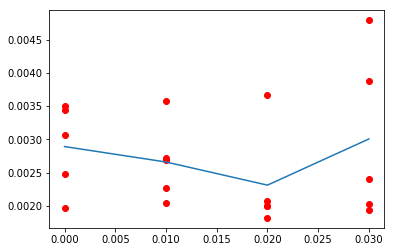

In [36]:
import matplotlib.pyplot as plt
%matplotlib inline

x_points = []
y_points = []

x_points_mean = []
y_means =[]

for key, value in sorted(correction_results.items()):
    mean = 0
    for v in value:
        x_points.append(key)
        y_points.append(v)
        mean += v
    mean /= len(value)
    x_points_mean.append(key)
    y_means.append(mean)
        
plt.plot(x_points,y_points,'ro')
plt.plot(x_points_mean,y_means)

plt.show()

## Results
As expected the different correction terms produce training data of different consistency. According to our experiments, a correction term of 0.02 seems to be appropriate.